In [2]:
#%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import wandb

import time
import random
import copy
from copy import deepcopy
import threading

from train_utils import *

import gym3
from procgen import ProcgenGym3Env
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'; device

'cuda'

In [35]:
bs = 64
all_colors = [0,1,2,3,4,5,6,7]
background_noise = 100
no_background_noise = 0
configs = [
    { 
        'name':'rc_mid_outdist_no_backnoise',
        'color_theme_indist': all_colors,
        'color_theme_outdist': all_colors,
        'color_theme_road_indist': [0,1,2,5,6,7],
        'color_theme_road_outdist': [3,4],
        'background_noise_level_indist': background_noise,
        'background_noise_level_outdist': 0
    }
]

In [36]:
def get_env(dist, config):
    return ProcgenGym3Env(num=bs, env_name="testgame", num_levels=100_000, start_level=0,
                         color_theme=config['color_theme_'+dist],
                         color_theme_road=config['color_theme_road_'+dist],
                         background_noise_level=config['background_noise_level_'+dist])

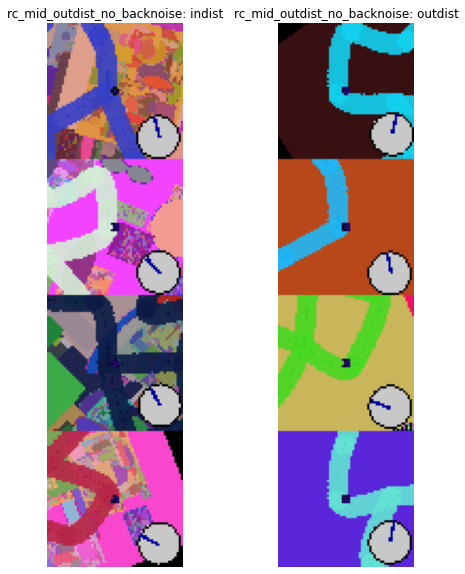

In [37]:
config = configs[0]

s = np.array([[.0,.0] for _ in range(bs)], dtype=np.float32)
seq_len = 15
N_IMGS = 4

plt.figure(figsize=(20, 10))

titles=['indist', 'outdist']

for i, title in enumerate(titles):
    ax = plt.subplot(1,5, i+1)
    env = get_env(title, config)

    for i in range(seq_len):
        env.act(s)
        rew, obs, first = env.observe()
        img = obs['rgb']
        img = np.concatenate(img[:N_IMGS],0)
        info = env.get_info()
        
    plt.imshow(img)
    plt.title(f"{config['name']}: {title}")
    plt.axis("off")

In [4]:
def testdrive(m, dist, use_autopilot, config):
    TRAINING_WHEELS_WINDOW = 10
    m.eval()
    seq_len = 300
    val_env = get_env(dist, config)
    s = np.array([[.0,.0] for _ in range(bs)], dtype=np.float32)
    reward = 0
    with torch.no_grad():
        for i in range(seq_len):
            val_env.act(s)
            rew, obs, first = val_env.observe()
            reward += rew.sum()
            img = obs['rgb']
            info = val_env.get_info()
            autopilot_control = np.array([[e["autopilot_"+c] for c in control_properties] for e in info])
            aux = np.array([[e[a] for a in aux_properties] for e in info])
            front = torch.from_numpy(img.astype(np.float32)/255.).unsqueeze(0).permute(0,1,4,2,3).to(device)
            aux = torch.from_numpy(aux.astype(np.float32)).unsqueeze(0).to(device)
            
            if use_autopilot or i < TRAINING_WHEELS_WINDOW:
                s = autopilot_control
            else:
                out, _ = m(front, aux, '')
                s = out.squeeze(0).squeeze(-1).cpu().numpy()
                s = np.clip(s, -5., 5.)
        
    reward /= (bs*seq_len)
    val_env.close()
    m.train()
    return reward

In [5]:
loss_fn = torch.nn.MSELoss().cuda()
def get_model():
    m = VizCNN(use_rnn=False).to(device);
    opt = torch.optim.Adam(m.parameters(), lr=3e-4)
    scaler = torch.cuda.amp.GradScaler() 
    return m, opt, scaler

In [6]:

def train(config, wandb_run=None):
    m, opt, scaler = get_model()
    global bs
    dataloader = DataLoader(env=get_env(dist='indist', config=config), bs=bs, seq_len=200)
    autopilot_score_indist = testdrive(m, 'indist', use_autopilot=True, config=config)
    autopilot_score_outdist = testdrive(m, 'outdist', use_autopilot=True, config=config)

    m.train()
    logger = Logger()
    n_updates = 15_100
    counter = 1
    log_cadence = 5_000
    bptt = 1

    while counter < n_updates:
        front_container, aux_container, target_container = dataloader.get_chunk()
        chunk_len, bs, _, _, _ = front_container.shape
        len_ix = 0
        while len_ix < chunk_len:
            front = front_container[len_ix:len_ix+bptt, :, :, :, :].to(device).half()
            aux = aux_container[len_ix:len_ix+bptt, :, :].to(device).half()
            target = target_container[len_ix:len_ix+bptt, :, :].to(device).half()
            len_ix += bptt*4
            with torch.cuda.amp.autocast(): pred, _ = m(front, aux, '')  
            loss = loss_fn(target, pred)
            scaler.scale(loss).backward() 
            scaler.step(opt) 
            scaler.update() 
            opt.zero_grad()
            counter += 1

            if counter % log_cadence == 0:
                val_score_indist = testdrive(m, 'indist', use_autopilot=False, config=config) / autopilot_score_indist
                val_score_outdist = testdrive(m, 'outdist', use_autopilot=False, config=config) / autopilot_score_outdist
                logger.log({
                    "score_indist":np.round(val_score_indist,2),
                    "score_outdist":np.round(val_score_outdist,2)
                })
                stats = logger.finish()
                print(stats)
                if wandb_run:
                    wandb.log(stats)
    
    dataloader.destroy()
    del dataloader, m

In [ ]:
n_seeds = 3
experiment_name = 'road color, backnoise'

for config in configs:
    for _ in range(n_seeds):
        with wandb.init(project="domain-randomization", group=config['name'], tags=[experiment_name]) as wandb_run:
            train(config, wandb_run)
            

wandb: Currently logged in as: rgilman33 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


building procgen...done
{'score_indist': 1.01, 'score_outdist': 1.01}
{'score_indist': 0.99, 'score_outdist': 1.02}
